In [45]:
## Replicating the CIFAR-10 Image classification 

import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [46]:
#Steps to classify
# 1. import + process data
# 2. create architecture
# 3. Run training + validation
# 4. test
# 5. Plot images to see

In [47]:
import numpy as np

num_workers = 20
batch_size = 20
valid_size = 0.2

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.CIFAR10('data', train=True,download=True,transform=transform)
test_data = datasets.CIFAR10('data', train=False,download=True,transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
               
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size,num_workers=num_workers)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [48]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 conv layers, 1 pool maxPool, and then 2 linear layers + dropout
        #image comes in as 32x32, and depth of 3 for RGB
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*4*4, 500)
        self.fc2 = nn.Linear(500,10)
        self.dropout = nn.Dropout(0.25)     
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1 , 64*4*4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [49]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [52]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for data, target in train_loader:
       
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    model.eval()
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1aa5a7550>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1174, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Epoch: 1 	Training Loss: 1.847567 	Validation Loss: 1.656996
Validation loss decreased (inf --> 1.656996).  Saving model ...
Epoch: 2 	Training Loss: 1.575577 	Validation Loss: 1.483887
Validation loss decreased (1.656996 --> 1.483887).  Saving model ...
Epoch: 3 	Training Loss: 1.431802 	Validation Loss: 1.361604
Validation loss decreased (1.483887 --> 1.361604).  Saving model ...
Epoch: 4 	Training Loss: 1.329149 	Validation Loss: 1.280165
Validation loss decreased (1.361604 --> 1.280165).  Saving model ...
Epoch: 5 	Training Loss: 1.236418 	Validation Loss: 1.184825
Validation loss decreased (1.280165 --> 1.184825).  Saving model ...
Epoch: 6 	Training Loss: 1.151844 	Validation Loss: 1.088424
Validation loss decreased (1.184825 --> 1.088424).  Saving model ...
Epoch: 7 	Training Loss: 1.074139 	Validation Loss: 1.026451
Validation loss decreased (1.088424 --> 1.026451).  Saving model ...
Epoch: 8 	Training Loss: 1.012974 	Validation Loss: 0.984206
Validation loss decreased (1.02645

In [53]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [55]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for data, target in test_loader:
   
  
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) 
   
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.719841

Test Accuracy of airplane: 77% (775/1000)
Test Accuracy of automobile: 88% (881/1000)
Test Accuracy of  bird: 61% (615/1000)
Test Accuracy of   cat: 62% (624/1000)
Test Accuracy of  deer: 66% (664/1000)
Test Accuracy of   dog: 68% (689/1000)
Test Accuracy of  frog: 78% (783/1000)
Test Accuracy of horse: 81% (817/1000)
Test Accuracy of  ship: 87% (878/1000)
Test Accuracy of truck: 81% (816/1000)

Test Accuracy (Overall): 75% (7542/10000)


<ipython-input-91-301871d5e2cb>:21: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


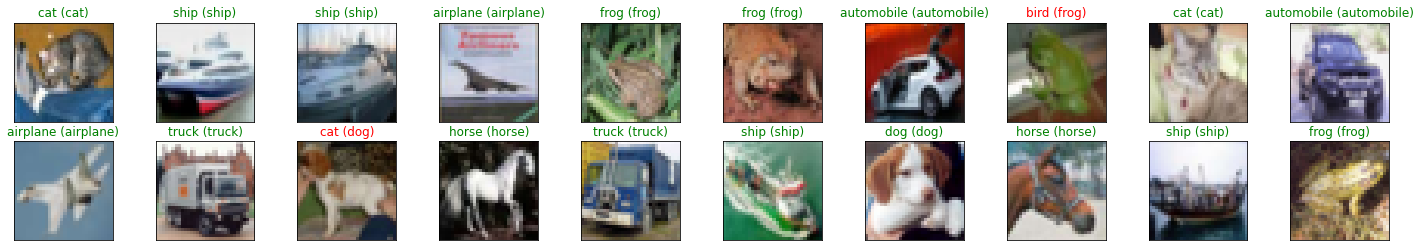

In [91]:
import matplotlib.pyplot as plt
# obtain one batch of test images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()


# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx]) 
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
